# Regional and country-level averages

Try area-weighted and country-level avg

In [1]:
# necessary:  netcdf4-python, regionmask (automatically imports xarray), Cartopy, openpyxl,( statsmodels - do i need this ?), seaborn

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
%matplotlib inline
import seaborn as sns

import xarray as xr
import geopandas as gpd
import regionmask as regionmask
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import netCDF4
from scipy.stats import norm



In [2]:
from settings_ana import *
from functions_ana import * 
from plotscript import * # is there anything here im using?
 

In [142]:
# import other packages/modules 
sys.path.append(os.path.join(os.environ['VSC_DATA_VO_USER'],'demographics4climate/'))
from population_demographics import * 

In [3]:
start_message()

flags: {'models': 'ISIMIP3b', 'experiment': None, 'metric': 'WBGT28', 'method': None, 'time_method': None, 'shift_sigma': False, 'shift_period': None, 'shift_loglike': None, 'chunk_version': None, 'var': 'wbgt'}
var: wbgt
VARs: None
indir_p: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/InputData/climate/atmosphere/bias-adjusted/global/daily/
indir_s: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3b/SecondaryInputData/climate/atmosphere/bias-adjusted/global/daily/
indir_obs: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/obsclim/global/daily/historical/
indir_counterclim: /data/brussel/vo/000/bvo00012/data/dataset/ISIMIP/ISIMIP3a/InputData/climate/atmosphere/counterclim/global/daily/historical/
GCMs: ['CanESM5', 'CNRM-CM6-1', 'GFDL-ESM4', 'IPSL-CM6A-LR', 'MIROC6', 'MRI-ESM2-0', 'EC-Earth3', 'UKESM1-0-LL', 'MPI-ESM1-2-HR', 'CNRM-ESM2-1']
datasets: ['GSWP3-W5E5', '20CRv3-ERA5', '20CRv3-W5E5']
lat_chunk: 90
lon_chunk: 120
tim

In [4]:
# SETTINGS
figdir = os.path.join(figdirs, 'fig_sep24')

# plot settings
matplotlib.rc('axes',edgecolor='k')
fg_color = 'k' 

# geo information
landmask = get_mask()
cellarea = xr.open_dataarray(os.path.join(datadirs,'geo-information/clm45_area.nc4'))

In [5]:
def reporting_summary(df, args, axis=1):
    #summary = {arg: getattr(df, arg)(axis=axis) for arg in args}
    summary = {}
        # Iterate over each requested summary statistic
    for arg in args:
        if arg == "q1":
            summary["Q1"] = df.quantile(0.25, axis=axis)
        elif arg == "q3":
            summary["Q3"] = df.quantile(0.75, axis=axis)
        else:
            # Handle standard functions like "min", "max", "median"
            summary[arg] = getattr(df, arg)(axis=axis)
    
    # Concatenate results along columns
    df_summary = pd.concat(summary, axis=1)
    
    return df_summary.astype('float64').round(2)

# 1. nAHD (WBGT28) 

## Reanalysis

To do:
- do some regional/focus area analysis, worst hit areas etc.
- check covariate value for present and GWI value (GHG=1.45 or anthro=1.29?) - or real time online 1.304 (i think this is anthro)

Notes:
- very similar to ATTRICI obsclim v. counterclim (see isimip3a-wbgt-obsclim-counterclim), same patterns but larger numbers here, bc ref periods are also shifted

In [6]:
# open data
flags['models']='ISIMIP3a'
dirname = 'output_shift-fit' 

da_list = []

for i in range(len(datasets)):
    dataset = datasets[i]
    filepath = glob.glob(os.path.join(outdirs, 
                                      f'output_shift-fit/forster2024/WBGT/ISIMIP3a/{dataset}/*_obsclim_WBGT_params_shift_loc_mon_loglike_1901_2019.nc'))[0]
    da = xr.open_dataarray(filepath).expand_dims("dataset").assign_coords(dataset=("dataset", [dataset]))
    da_list.append(da)
    da_params = xr.concat(da_list, dim="dataset")
    

In [7]:
gmst_smo = get_gmst_smo(ntime=4, observed_warming_path=observed_warming_path_annual)
#gmst_smo

In [8]:
threshold = 28

da_nAHD_obs, da_nAHD_mo, da_p0, da_p1 = calc_nAHD_shift_fit(da_params, threshold, gmst_smo,year_pres=2023,GWI=1.3)

## 2. Climate models 


In [9]:
dirname='output_empirical'
models='ISIMIP3b'

year=2023

da_nAHD_models = open_all_nAHD(GCMs,  metric='WBGT28', outdirname=dirname, year_pres=year) 
empty, da_p1_models = open_all_p0_p1(GCMs, metric='WBGT28', outdirname=dirname, year_pres=year)

In [10]:
da_nAHD_models

<xarray.DataArray 'number of additional days' (model: 10, lat: 360, lon: 720)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * lon      (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat      (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * model    (model) <U13 'CanESM5' 'CNRM-CM6-1' ... 'CNRM-ESM2-1'

## 3. IPCC AR6 land regions averages

In [11]:
regionmask.defined_regions.ar6.land

<regionmask.Regions 'AR6 reference regions (land only)'>
Source:   Iturbide et al., 2020 (ESSD)
overlap:  False

Regions:
 0 GIC Greenland/Iceland
 1 NWN N.W.North-America
 2 NEN N.E.North-America
 3 WNA   W.North-America
 4 CNA   C.North-America
..  ..               ...
41 EAU       E.Australia
42 SAU       S.Australia
43  NZ       New-Zealand
44 EAN      E.Antarctica
45 WAN      W.Antarctica

[46 regions]

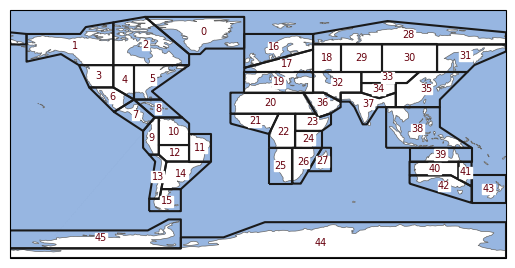

In [42]:
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

plot = regionmask.defined_regions.ar6.land.plot(text_kws=text_kws, add_ocean=True);

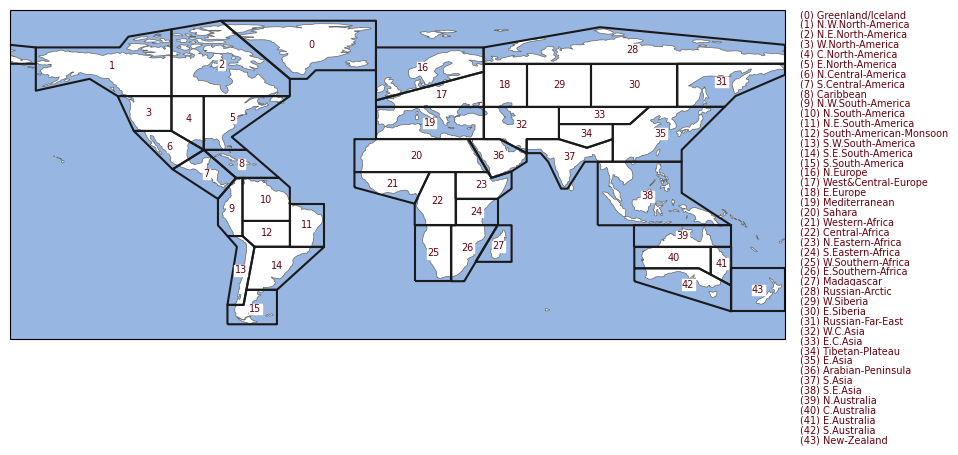

In [74]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Create the map projection and axis
f, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Define the text properties for region labels
text_kws = dict(color="#67000d", fontsize=7, bbox=dict(pad=0.2, color="w"))

# Plot the regions
indices = list(range(44))
regions = regionmask.defined_regions.ar6.land[indices]
plot = regions.plot(ax=ax, text_kws=text_kws, add_ocean=True)

# Get the region mask with names
mask = regions.mask_3D(da_nAHD_models)
region_labels = ['('+str(i)+') '+str(name) for i, name in zip(mask.region.values, mask.names.values)]

# Add the region labels as a list on the right side of the plot
for idx, label in enumerate(region_labels):
    ax.text(
        1.02, 1 - idx * 0.03,  # Coordinates for the label placement
        label,
        transform=ax.transAxes,   # Position relative to the axis (1.05, y) to place it outside the plot
        ha="left", va="top",
        color="#67000d",
        fontsize=7,
        bbox=dict(pad=0.2, color="w")
    )

# Save the figure
#plt.savefig(os.path.join(figdir,"IPCC_AR6_regions_labelled.png"), dpi=300, bbox_inches="tight")



In [13]:
mask = regionmask.defined_regions.ar6.land.mask_3D(da_nAHD_models)
mask.abbrevs

<xarray.DataArray 'abbrevs' (region: 46)>
array(['GIC', 'NWN', 'NEN', 'WNA', 'CNA', 'ENA', 'NCA', 'SCA', 'CAR',
       'NWS', 'NSA', 'NES', 'SAM', 'SWS', 'SES', 'SSA', 'NEU', 'WCE',
       'EEU', 'MED', 'SAH', 'WAF', 'CAF', 'NEAF', 'SEAF', 'WSAF', 'ESAF',
       'MDG', 'RAR', 'WSB', 'ESB', 'RFE', 'WCA', 'ECA', 'TIB', 'EAS',
       'ARP', 'SAS', 'SEA', 'NAU', 'CAU', 'EAU', 'SAU', 'NZ', 'EAN',
       'WAN'], dtype='<U4')
Coordinates:
  * region   (region) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
    abbrevs  (region) <U4 'GIC' 'NWN' 'NEN' 'WNA' ... 'SAU' 'NZ' 'EAN' 'WAN'
    names    (region) <U22 'Greenland/Iceland' ... 'W.Antarctica'

In [269]:
# regionlabels = [str(name)+' ('+str(i)+')' for i, name in zip(mask.region.values, mask.names.values) ]
# np.array(regionlabels)

# Get the region mask with names
region_labels = ['('+str(i)+') '+str(name) for i, name in zip(mask.region.values, mask.names.values)]


In [270]:
da_nAHD_mod_regional = da_nAHD_models.weighted(mask * cellarea).mean(dim=("lat", "lon"))
#da_nAHD_mod_regional.to_pandas().T

In [271]:
da_nAHD_obs_regional = da_nAHD_obs.weighted(mask * cellarea).mean(dim=("lat", "lon"))
#da_nAHD_obs_regional.to_pandas().T

In [272]:
df_mod = da_nAHD_mod_regional.to_pandas().T[0:44] # get rid of antarctica 44:45 
df_obs = da_nAHD_obs_regional.to_pandas().T[0:44]
df = pd.merge(df_obs, df_mod, left_index=True, right_index=True).set_index(np.array(region_labels)[0:44])
#df

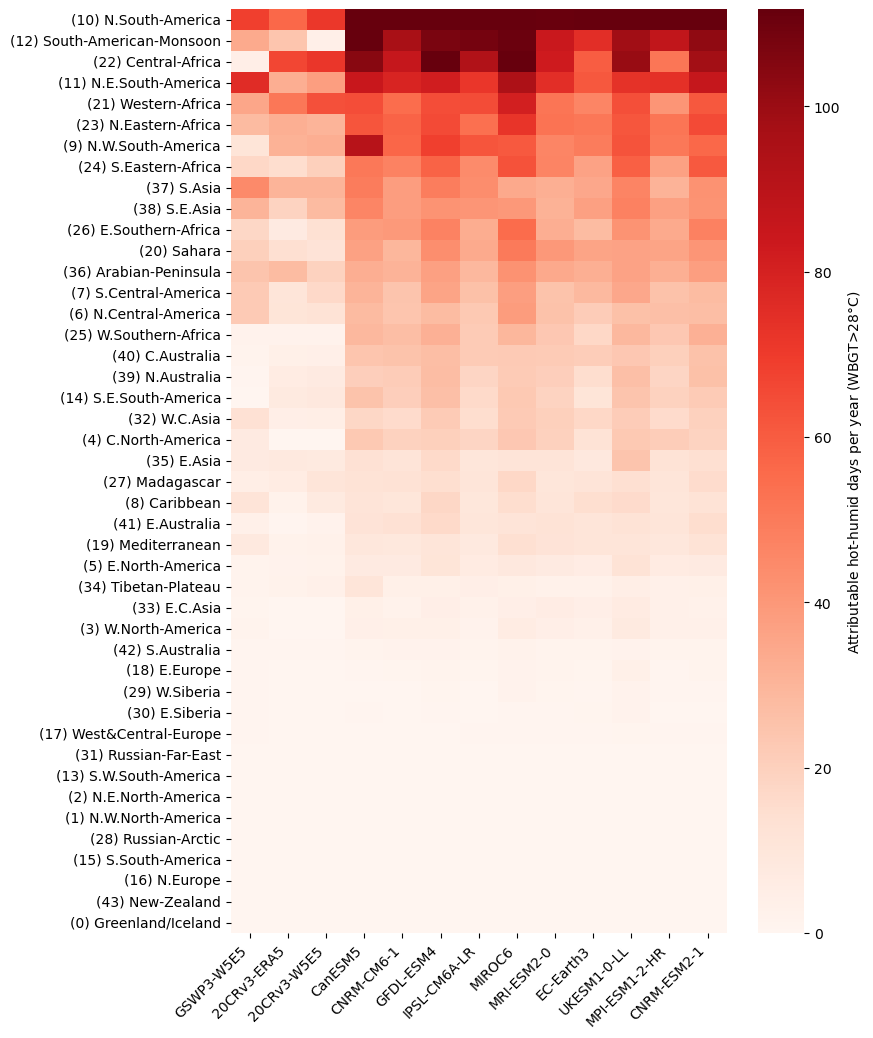

In [273]:
plt.figure(figsize=(8, 12))
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values]
sns.heatmap(df_sorted, annot=False,  cmap='Reds', robust=True, cbar=True, cbar_kws={'label':'Attributable hot-humid days per year (WBGT>28$\degree$C)'})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

#plt.savefig(os.path.join(figdir,"heatmap_nAHD_WBGT28_IPCC_AR6_regions.png"), dpi=300, bbox_inches="tight")


In [274]:
df.min(), df.max()

(GSWP3-W5E5      -6.157594
 20CRv3-ERA5     -3.324687
 20CRv3-W5E5     -4.055854
 CanESM5          0.000000
 CNRM-CM6-1       0.000000
 GFDL-ESM4       -0.000010
 IPSL-CM6A-LR    -0.001220
 MIROC6           0.000000
 MRI-ESM2-0       0.000000
 EC-Earth3       -0.000003
 UKESM1-0-LL      0.000000
 MPI-ESM1-2-HR    0.000000
 CNRM-ESM2-1      0.000000
 dtype: float64,
 GSWP3-W5E5        75.590809
 20CRv3-ERA5       66.494344
 20CRv3-W5E5       71.715410
 CanESM5          195.003139
 CNRM-CM6-1       128.978506
 GFDL-ESM4        161.298149
 IPSL-CM6A-LR     144.141297
 MIROC6           131.603537
 MRI-ESM2-0       111.247579
 EC-Earth3        125.751306
 UKESM1-0-LL      146.327585
 MPI-ESM1-2-HR    125.862237
 CNRM-ESM2-1      123.222923
 dtype: float64)

### Plot

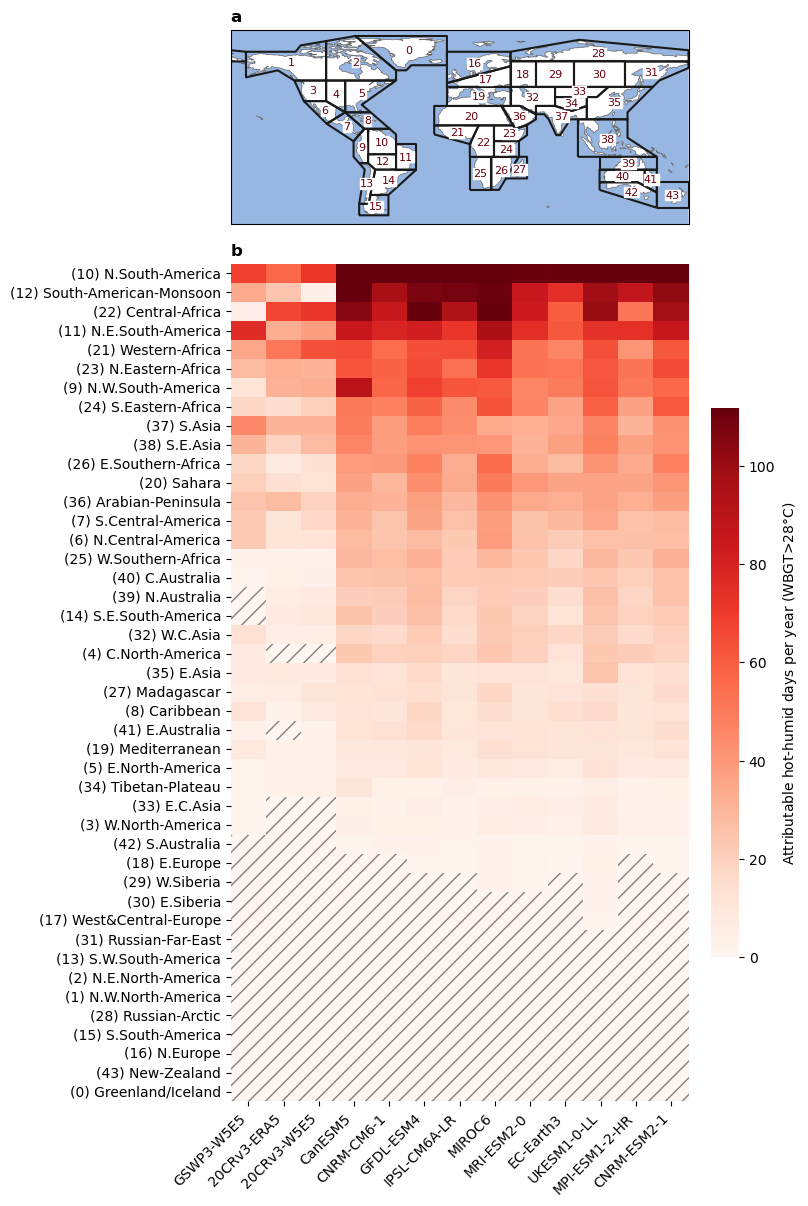

In [335]:
from matplotlib.colors import LogNorm


# Create fig and gridspec
fig = plt.figure(figsize=(8, 12), layout='constrained')  
gs = gridspec.GridSpec(2, 1, height_ratios=[1,4],figure=fig)  


# Plot the regions
ax= fig.add_subplot(gs[0, 0], projection= ccrs.PlateCarree()) 
text_kws = dict(color="#67000d", fontsize=8, bbox=dict(pad=0.2, color="w")) # Define the text properties for region labels
indices = list(range(44))
regions = regionmask.defined_regions.ar6.land[indices] # subselect regions w/out Antarctica
plot = regions.plot(ax=ax, text_kws=text_kws, add_ocean=True) # plot 
ax.set_title('a', loc='left', fontweight='bold')

# Plot heatmap
ax= fig.add_subplot(gs[1, 0])  
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values]
sns.heatmap(df_sorted, ax=ax, annot=False,  cmap='Reds', robust=True, cbar=True, cbar_kws={'label':'Attributable hot-humid days per year (WBGT>28$\degree$C)', 'fraction': 0.06})
plt.xticks(rotation=45, ha='right');
ax.set_title('b', loc='left',fontweight='bold')


data = df_sorted.values

# Overlay hatching for cells where values are less than 1
hatch_mask = data < 1 
# Apply hatching by using pcolor on masked areas
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, hatch='//', fill=False, edgecolor='gray', linewidth=0))


##plt.savefig(os.path.join(figdir,"figSI_heatmap_nAHD_WBGT28_IPCC_AR6_regions_v2.png"), dpi=300, bbox_inches="tight")

### Reporting tables (to save/format/export)

Pick multi-model mean+range or median+IQR

In [276]:
df_obs = df.iloc[:, 0:3]
df_obs_summary=reporting_summary(df_obs, ['mean', 'median', 'min', 'max', 'q1', 'q3'])
df_obs_summary.sort_values('median', ascending=False)

#df_obs_summary.to_csv()

,mean,median,min,max,Q1,Q3
(10) N.South-America,65.68,68.85,56.73,71.45,62.79,70.15
(22) Central-Africa,47.60,66.49,4.58,71.72,35.54,69.10
(21) Western-Africa,50.03,51.42,35.27,63.40,43.34,57.41
(11) N.E.South-America,48.59,37.76,32.43,75.59,35.09,56.68
(9) N.W.South-America,24.99,31.04,11.33,32.59,21.18,31.81
(37) S.Asia,35.20,30.51,30.25,44.84,30.38,37.67
(23) N.Eastern-Africa,30.05,30.25,28.00,31.91,29.13,31.08
(38) S.E.Asia,25.76,28.15,18.94,30.18,23.55,29.17
(36) Arabian-Peninsula,23.92,24.68,19.25,27.83,21.97,26.26
(12) South-American-Monsoon,20.80,24.24,4.29,33.88,14.26,29.06


In [279]:
df_mod = df.iloc[:, 3:]
df_mod_summary=reporting_summary(df_mod, ['mean', 'median', 'min', 'max', 'q1','q3'])
df_mod_summary.sort_values('median', ascending=False).round(0)


,mean,median,min,max,Q1,Q3
(10) N.South-America,139.0,130.0,111.0,195.0,126.0,146.0
(12) South-American-Monsoon,103.0,100.0,75.0,162.0,90.0,108.0
(22) Central-Africa,90.0,96.0,52.0,113.0,83.0,103.0
(11) N.E.South-America,78.0,77.0,61.0,95.0,74.0,84.0
(21) Western-Africa,59.0,63.0,41.0,81.0,53.0,64.0
(23) N.Eastern-Africa,59.0,60.0,51.0,72.0,53.0,64.0
(9) N.W.South-America,61.0,59.0,46.0,91.0,52.0,63.0
(24) S.Eastern-Africa,50.0,49.0,36.0,63.0,45.0,59.0
(38) S.E.Asia,40.0,40.0,31.0,48.0,38.0,42.0
(37) S.Asia,40.0,40.0,31.0,49.0,34.0,46.0


# 2. People x days


In [143]:
gs_population_global = population_demographics_gridscale_global(startyear=2023,
                                                                endyear=2023,
                                                                ssp=2,
                                                                urbanrural=False)

loading country masks
interpolating cohort sizes per country
calculating gridscale demographics


## young people

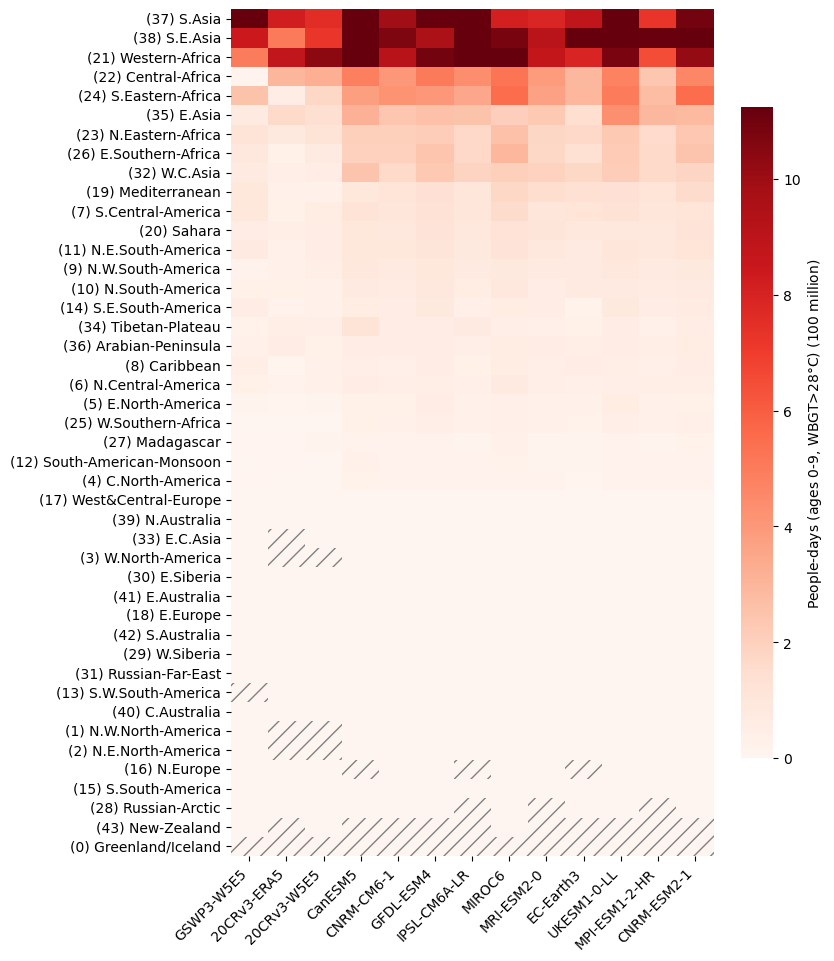

In [343]:
people_days_models = (da_nAHD_models * gs_population_global.sel(ages=0).squeeze('time'))
people_days_obs = (da_nAHD_obs * gs_population_global.sel(ages=0).squeeze('time'))

peopledays_mod_regional = people_days_models.weighted(mask).sum(dim=("lat", "lon"))
#peopledays_mod_regional.to_pandas().T

peopledays_obs_regional = people_days_obs.weighted(mask).sum(dim=("lat", "lon"))
#peopledays_obs_regional.to_pandas().T

df_mod = peopledays_mod_regional.to_pandas().T
df_obs = peopledays_obs_regional.to_pandas().T
df_peopledays = pd.merge(df_obs, df_mod, left_index=True, right_index=True).set_index(np.array(region_labels)[0:44])
#df_peopledays



fig, ax = plt.subplots(figsize=(7, 11))

df_sorted = df_peopledays.loc[df_peopledays.mean(axis=1).sort_values(ascending=False).index.values] / 1e8
sns.heatmap(df_sorted, ax=ax,annot=False, cmap='Reds', robust=True,  cbar=True, cbar_kws={'label':'People-days (ages 0-9, WBGT>28$\degree$C) (100 million)', 'fraction': 0.06}) #

plt.xticks(rotation=45, ha='right');

data = df_sorted.values

# Overlay hatching for cells where values are less than 1
hatch_mask = data < ( 1e2 / 1e8)
# Apply hatching by using pcolor on masked areas
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        if hatch_mask[i, j]:
            ax.add_patch(plt.Rectangle((j, i), 1, 1, hatch='//', fill=False, edgecolor='gray', linewidth=0))


#plt.savefig(os.path.join(figdir,"figSI_peopledays_09_heatmap_IPCC_AR6_regions_v2.png"), dpi=300, bbox_inches="tight")

## older people

In [180]:
people_days_models = (da_nAHD_models * gs_population_global.sel(ages=60).squeeze('time'))
people_days_obs = (da_nAHD_obs * gs_population_global.sel(ages=60).squeeze('time'))

peopledays_mod_regional = people_days_models.weighted(mask).sum(dim=("lat", "lon"))
#peopledays_mod_regional.to_pandas().T

peopledays_obs_regional = people_days_obs.weighted(mask).sum(dim=("lat", "lon"))
#peopledays_obs_regional.to_pandas().T

df_mod = peopledays_mod_regional.to_pandas().T
df_obs = peopledays_obs_regional.to_pandas().T
df_peopledays_60 = pd.merge(df_obs, df_mod, left_index=True, right_index=True).set_index(np.array(region_labels)[0:44])
#df_peopledays

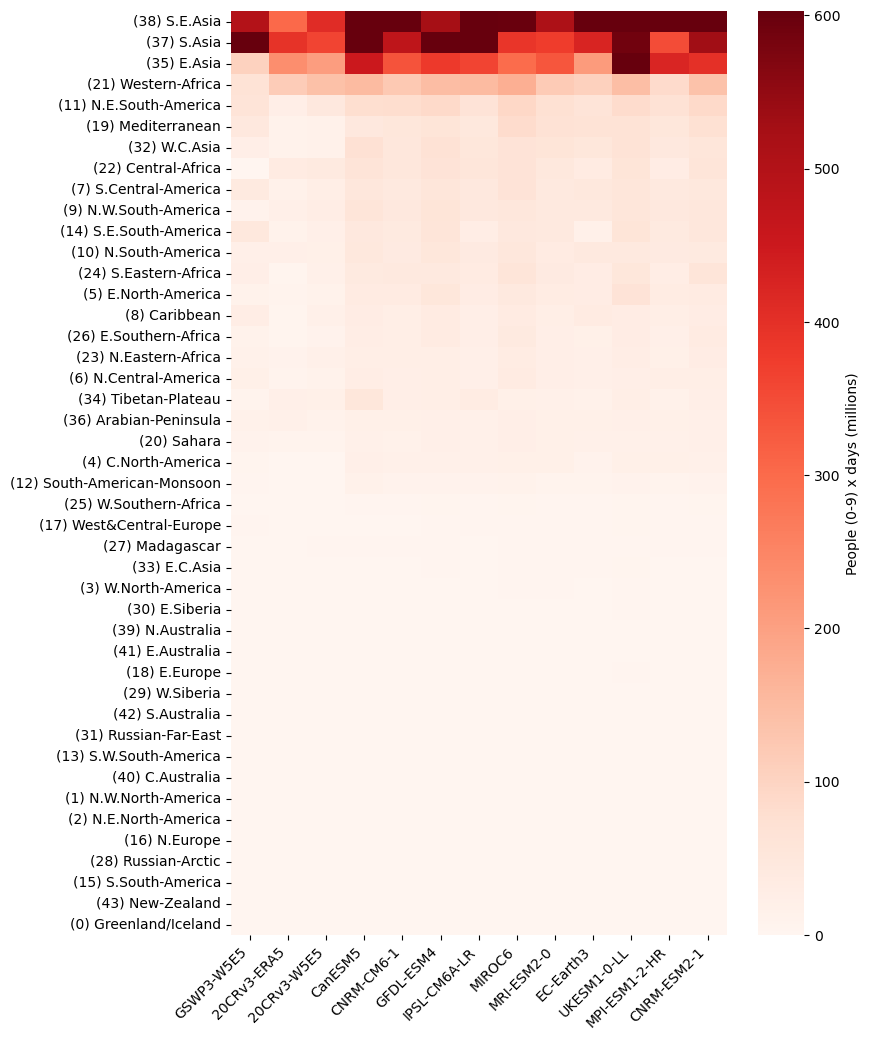

In [192]:
plt.figure(figsize=(8, 12))
df_sorted = df_peopledays_60.loc[df_peopledays_60.mean(axis=1).sort_values(ascending=False).index.values] / 1e6
sns.heatmap(df_sorted, annot=False,  cmap='Reds', robust=True, cbar=True, cbar_kws={'label':'People (0-9) x days (millions)'})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

#plt.savefig(os.path.join(figdir,"heatmap_nAHD_WBGT28_IPCC_AR6_regions.png"), dpi=300, bbox_inches="tight")

## ratio younger / older peoplexdays in each region

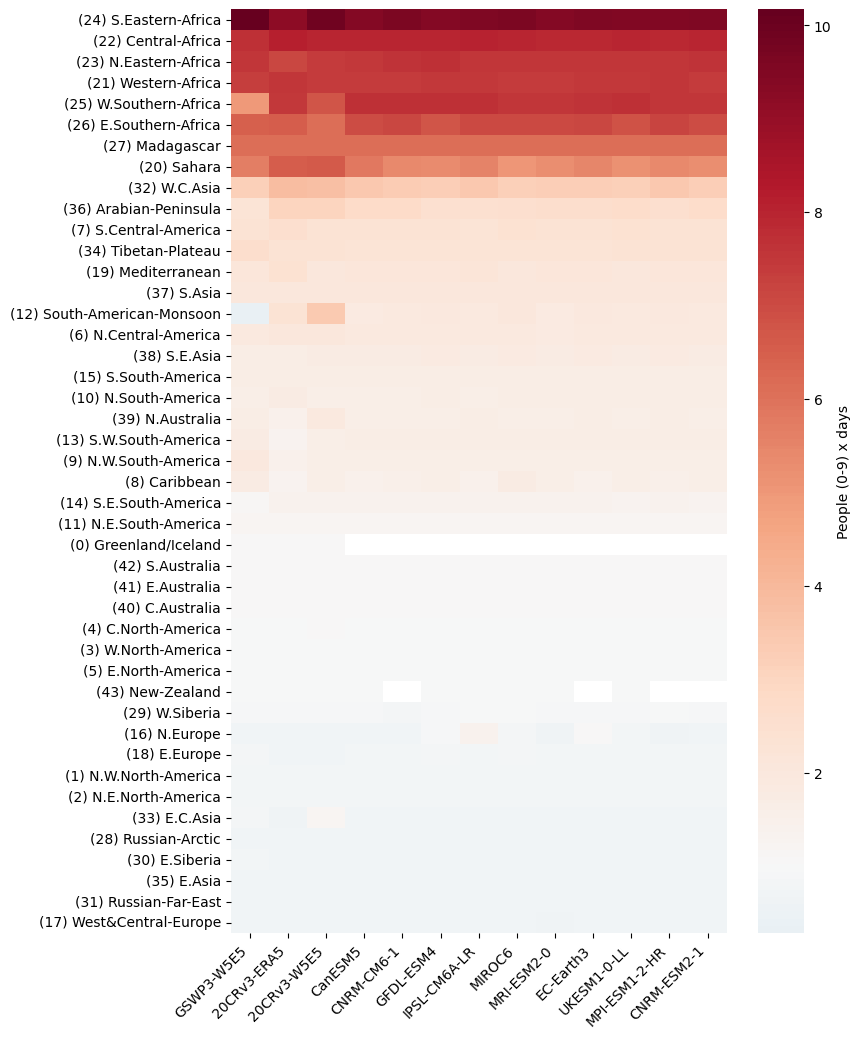

In [185]:
plt.figure(figsize=(8, 12))
df = df_peopledays / df_peopledays_60
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values]
sns.heatmap(df_sorted, annot=False,  cmap='RdBu_r', center=1, robust=False, cbar=True, cbar_kws={'label':'People (0-9) x days'})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

## ratio younger / older people

In [201]:
people_young =  gs_population_global.sel(ages=0).squeeze('time')
people_old = gs_population_global.sel(ages=60).squeeze('time')

people_young_regional = people_young.weighted(mask).sum(dim=("lat", "lon"))
people_old_regional = people_old.weighted(mask).sum(dim=("lat", "lon"))

df_young = pd.DataFrame(people_young_regional.to_pandas().T).set_index(np.array(region_labels)[0:44])
df_old = pd.DataFrame(people_old_regional.to_pandas().T).set_index(np.array(region_labels)[0:44])



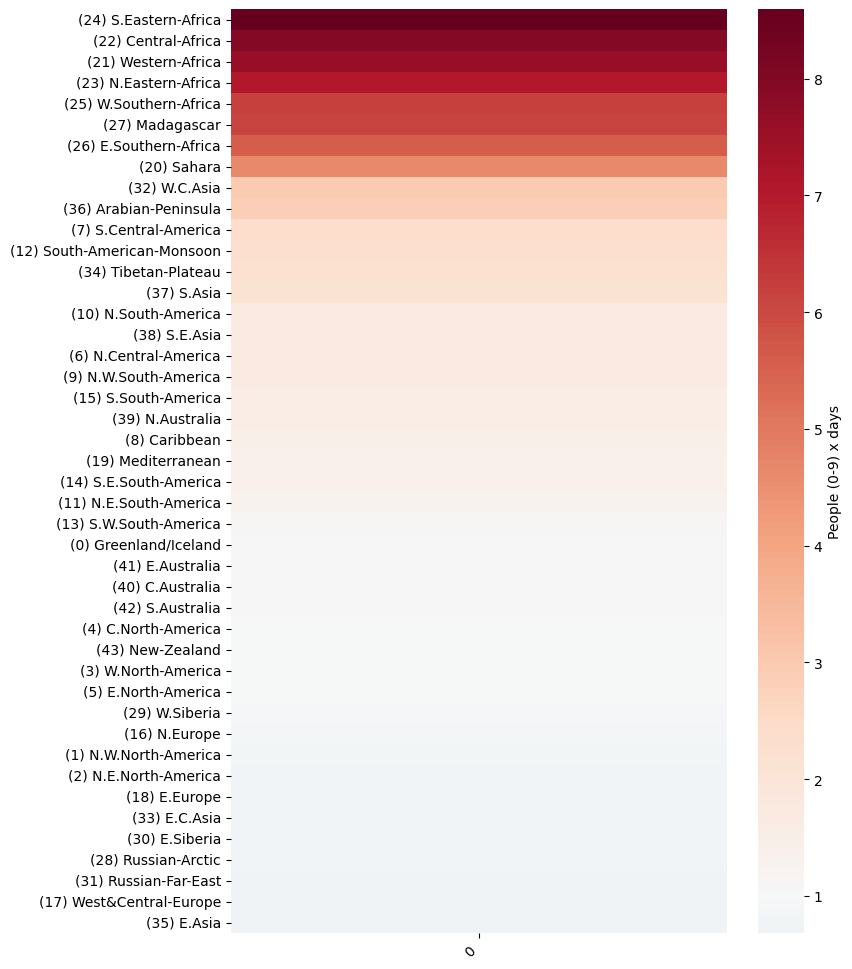

In [202]:
plt.figure(figsize=(8, 12))
df = df_young / df_old
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values]
sns.heatmap(df_sorted, annot=False,  cmap='RdBu_r', center=1, robust=False, cbar=True, cbar_kws={'label':'People (0-9) x days'})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

## ratio young peoplexdays to total global peoplexdays


In [220]:
people_young =  gs_population_global.sel(ages=0).squeeze('time')
people_tot = gs_population_global.sum(dim='ages').squeeze('time') #

people_days_young = (da_nAHD_models * people_young)
people_days_tot = (da_nAHD_models * people_tot ).sum(dim=("lat", "lon"))

peopledays_frac_regional = people_days_young.weighted(mask).sum(dim=("lat", "lon")) / people_days_tot

df_models = pd.DataFrame(peopledays_frac_regional.to_pandas().T ).set_index(np.array(region_labels)[0:44])
#df_models


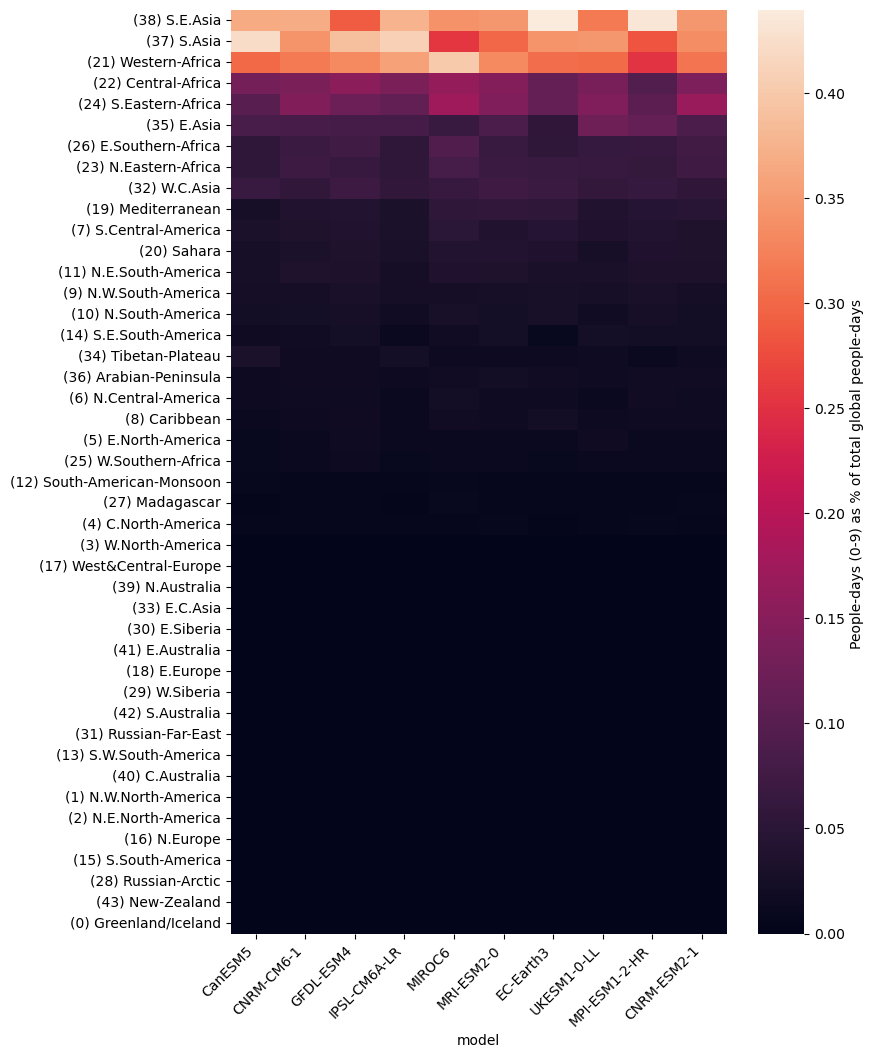

In [219]:
plt.figure(figsize=(8, 12))
df = df_models * 100
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values] 
sns.heatmap(df_sorted, annot=False,   robust=False, cbar=True, cbar_kws={'label':'People-days (0-9) as % of total global people-days '})


#plt.title("Attributable hot-humid days per year (WBGT>28$\degree$C)")
plt.xticks(rotation=45, ha='right');

## ratio young peoplexdays to young total global peoplexdays


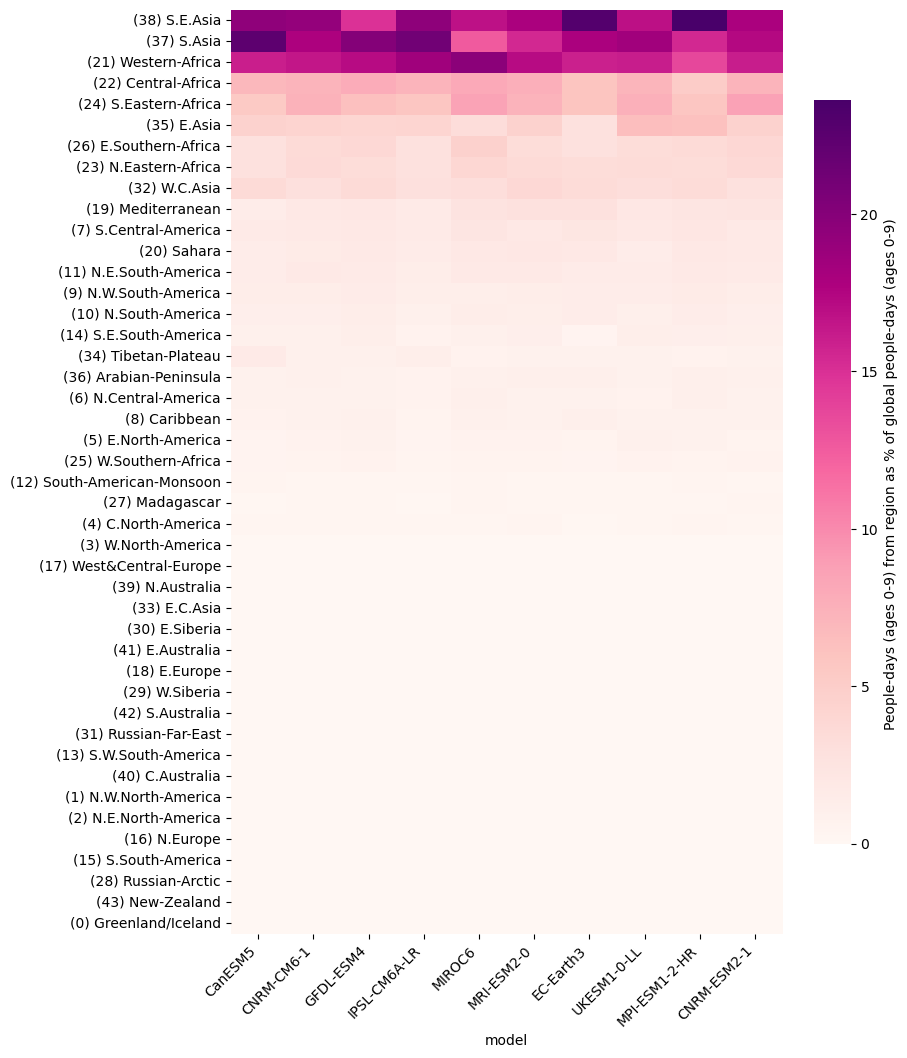

In [257]:
people_young =  gs_population_global.sel(ages=0).squeeze('time')
people_tot = gs_population_global.sel(ages=0).squeeze('time') #

people_days_young = (da_nAHD_models * people_young)
people_days_tot = (da_nAHD_models * people_tot ).sum(dim=("lat", "lon"))

peopledays_frac_regional = people_days_young.weighted(mask).sum(dim=("lat", "lon")) / people_days_tot

df_models = pd.DataFrame(peopledays_frac_regional.to_pandas().T ).set_index(np.array(region_labels)[0:44])

plt.figure(figsize=(8, 12))
df = df_models * 100
df_sorted = df.loc[df.mean(axis=1).sort_values(ascending=False).index.values] 
sns.heatmap(df_sorted, annot=False,   robust=False, cbar=True, cmap='RdPu', cbar_kws={'label':'People-days (ages 0-9) from region as % of global people-days (ages 0-9) ', 'fraction': 0.06})

plt.xticks(rotation=45, ha='right');

#plt.savefig(os.path.join(figdir,"figSI_peopledays_percentage09_heatmap_IPCC_AR6_regions.png"), dpi=300, bbox_inches="tight")

In [215]:
df_models.sum(axis=0)

model
CanESM5          0.994054
CNRM-CM6-1       0.993435
GFDL-ESM4        0.992115
IPSL-CM6A-LR     0.993908
MIROC6           0.994942
MRI-ESM2-0       0.993751
EC-Earth3        0.992710
UKESM1-0-LL      0.994143
MPI-ESM1-2-HR    0.992371
CNRM-ESM2-1      0.993652
dtype: float64